# Entrenamiento PM10 promedio móvil


Una vez que se tienen los datos limpios y procesados, estos pueden ser usados para la generación de los modelos. A continuación se muestra el flujo trabajo para la generación de los modelos:

<img src="./gen_modelos.png" style="height:300px">

Los modelos utilizados son del tipo __supervisado___, esto quiere decir que se necesita tener el valor real para poder generar los modelos, este valor corresponde a la columna del contaminante a pronosticar a una hora específica.  

Una vez que se tiene esta columna identificado, es necesario dividir los datos de entrenamiento en dos conjuntos: de __entrenamiento__ y __prueba__. La razón de dividirlos es para poder cuantiﬁcar el desempeño y el correcto funcionamiento de los modelos. El conjunto de entrenamiento correspondió al __80%__ de los datos totales y en éste se ejecutarán los modelos estadísticos para obtener los árboles de decisión y con el conjunto de prueba que correspondió al __20%__ restante, se comparará el pronóstico de los modelos con el valor real.

Con el conjunto de entrenamiento se ejecutaron todas las pruebas realizadas, aplicando los modelos de machine learning ya mencionados. Los modelos se optimizaron para tener un correcto pronóstico de valores alrededor del nivel de contaminación de la contingencia ambiental. Los modelos de los tres contaminantes son capaces de generar el pronóstico hasta de 24 horas, para cada hora se generó un modelo de manera que se generaron 24 modelos.


### Métricas de Valoración
Para medir el desempeño de un modelo de pronóstico es importante contar con una métrica de desempeño. Medir el desempeño del pronóstico es importante para saber que los métodos y características con los que trabaja el pronóstico son los adecuados. Además, calcular el desempeño de los modelos nos ayudará en la búsqueda de partes del pronóstico que no trabajen de manera óptima y con esto tomar decisiones para mejorar el desempeño del mismo. Las principales métricas usadas para medir el desempeño del modelo son el RMSE que nos indica qué tanto se aleja la predicción del valor real, la R2 que determina la calidad del modelo para replicar los resultados y la proporción de variación de los resultados que puede explicarse por el modelo y la precisión que nos indica cuántos falsos positivos genera el modelo es decir, cuántas contingencias son pronosticadas incorrectamente por cada contingencia pronosticada correctamente.


__Pasos y descripción general del notebook__


- __Datos recibidos:__ Limpieza de datos inicial
- __Responsable:__ Daniel Bustillos
- __Contacto:__  juandaniel.bucam@gmail.com


In [4]:
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_tree

from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#import missingno as msn

pd.options.mode.chained_assignment = None 

from sklearn.externals import joblib
from xgboost.sklearn import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor 

from sklearn.datasets import make_regression

from sklearn.metrics import confusion_matrix
from sklearn.metrics import fbeta_score, make_scorer

import seaborn as sn
from sklearn.metrics import confusion_matrix as confussion_matrix_function
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer

from sklearn.metrics import accuracy_score
from matplotlib import pyplot
# plot learning curve
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib import pyplot
import seaborn as sns
import random as rd
import time

#### Hacemos una función para obtenner el -promedio- de los dos modelos

In [5]:
def predictor_mean(model0_1,modelo_2,X_set):  
    #aplicamos los predict
    forecast_q = model0_1.predict(X_set) 
    forecast = modelo_2.predict(X_set)
   #generamos una lista dummy: 
    forecast_mean = forecast 
    
    for i in range(len(X_set)):
        if  forecast[i] < 135:
            forecast_mean[i] = forecast[i]
        elif  forecast_q[i] > 160:
            forecast_mean[i] = forecast_q[i]
        if  130 < forecast_q[i] <155 and 130 < forecast[i] < 155:
            forecast_mean[i] = (0.3*forecast_q[i] + 0.7*forecast[i])
        if  140 < forecast_q[i] <160 and 140 < forecast[i] < 160:
            forecast_mean[i] = (forecast_q[i] + forecast[i])/2
    return forecast_mean

Definimos el score [specifity](https://es.wikipedia.org/wiki/Especificidad_(epidemiología)) que se basa en el número de **TP** por cada **FP + FN**.

 $$Especifity = \frac{TP}{FP + FN}$$

## Hacemos una función para graficar

In [6]:
def ploter(y_test_0,X_test_0,pronosticados_0,model):
    
    plt.scatter(y_test_0, pronosticados_0,alpha=0.5,color="royalblue")
    score = round(model.score(X_test_0, y_test_0),3)
    rmse = round(np.sqrt(mean_squared_error(y_test_0, pronosticados_0)),3)
    plt.plot([30,130],[30,130],color="k",linestyle='--')
    
    plt.axhline(y=150, color='k', linestyle='--')
    plt.axvline(x=150, color='k', linestyle='--')
    plt.annotate('TP', (170,150), xytext = (175, 155 + 1), 
                  horizontalalignment='right')
    plt.annotate('FN', (170,150), xytext = (175, 135 + 1), 
                  horizontalalignment='right')
    plt.annotate('FP', (170,150), xytext = (125, 155 + 1), 
                  horizontalalignment='right')
    plt.annotate('FP', (170,150), xytext = (125, 135 + 1), 
                  horizontalalignment='right')
    plt.annotate("Score ="+str(score), (15,139), xytext = (15, 139 + 1), 
                  horizontalalignment='left')
    plt.annotate("RMSE ="+str(rmse), (15,119), xytext = (15, 119 + 1), 
                  horizontalalignment='left')
    
    
    plt.xlabel('Measured')
    plt.ylabel('Predicted')
    plt.title('Pronóstico con Persistencia Temporal')
    plt.show()

## Cargamos los modelos ya entrenados:

In [12]:
conta = 'PM25mean'

In [13]:
model = [0 for col in range(25)]
modelq = [0 for col in range(25)]

#### Cargamos los datos:

In [14]:
data_hour_merge = pd.read_csv(str("/DATA/paw/jupyterhub_notebook/daniel.bustillos/DanielBustillos/"+
                                  "contaminación/pipeline_norberto_11horas/datos/datos_modelos_"+conta+".csv"))

In [17]:
data_hour_merge['fecha'] = pd.to_datetime(data_hour_merge['fecha'], format='%Y-%m-%d %H:%M:%S')
data_hour_merge["hora"] = [row["fecha"].hour for index, row in data_hour_merge.iterrows()]

### Filtro de contingencia

In [21]:
data_hour_merge.columns.tolist()

['PM2.5_13.0_max',
 'PM2.5_30.0_min',
 'NO2_24.0_max',
 'PM10mean_40.0_min',
 'PM25mean_25.0_min',
 'PM25mean_13.0_min',
 'TMP_mean_frcst_8',
 'WSP_mean',
 'PM10mean_30.0_max',
 'PM10mean_16.0_min',
 'WSP_mean_frcst_1',
 'PM2.5_3.0_max',
 'PM10mean_38.0_min',
 'PM2.5_23.0_mean',
 'PM25mean_36.0_mean',
 'NO2_18.0_min',
 'PM10mean_19.0_min',
 'RH_mean_frcst_18',
 'TMP_mean_frcst_10',
 'NO2_4.0_max',
 'PM10mean_24.0_mean',
 'PM2.5_4.0_mean',
 'PM10mean_20.0_mean',
 'PM10mean_max',
 'PM2.5_8.0_min',
 'RH_mean_frcst_10',
 'PM25mean_mean',
 'PM10mean_36.0_min',
 'PM25mean_14.0_max',
 'RH_mean_frcst_19',
 'RH_max',
 'NO2_7.0_min',
 'PM10_27.0_max',
 'PM10mean_25.0_min',
 'PM10mean_mean',
 'PM2.5_27.0_mean',
 'PM2.5_6.0_mean',
 'TMP_min',
 'RH_mean_frcst_17',
 'TMP_mean_frcst_7',
 'NO2_max',
 'PM2.5_28.0_max',
 'PM25mean_33.0_mean',
 'PM25mean_19.0_min',
 'PM10_5.0_min',
 'PM2.5_21.0_max',
 'PM10_mean',
 'PM2.5_1.0_mean',
 'NO2_8.0_max',
 'TMP_mean_frcst_13',
 'NO_min',
 'NO2_7.0_mean',
 'PM10

In [19]:
data_hour_merge.loc[data_hour_merge["PM25mean_max_frcst_11"]>81.38, 'class'] = 1
data_hour_merge.loc[data_hour_merge["PM25mean_max_frcst_11"]<=81.38, 'class'] = 0

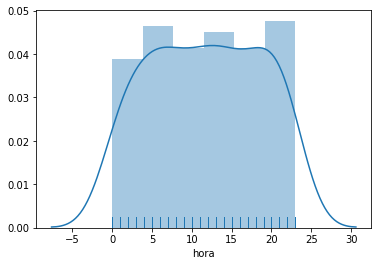

In [22]:
sns.distplot(data_hour_merge["hora"][data_hour_merge["PM25mean_max_frcst_1"]>81.38], kde=True, rug=True)

En contraste con la distriubción de precontingencias del Ozono, en el caso del PM10 y PM2.5, estas están distribuidas a lo largo del día, presumiblemente debido a que se considera el promedio móvil de las últimas 24 horas y no la medición puntual. 

> __Por este motivo vamos a hacer un 24 modelos, que pronostiquen a las 4am para cada hora del día.__

#### Filtramos por el día donnde se va a aplicar el pronóstico:

Definimos la lista de los targets:

### No aplica para PM10 o PM25
ya que la distribuciónn de contingencias es a lo largo del día

Borramos las columnas del target.

In [26]:
target = "PM25mean_max_frcst_"

lista = []
for i in range(1,25):
    lista.append(str(target+str(i)))

In [27]:
lista = []
for i in range(1,25):
    lista.append(str(target+str(i)))

In [28]:
conta = 'PM25mean'

## Training and verificationn split

Separamos en conjunto de verificacion y training según el anio:

In [29]:
data_hour_merge['fecha'] = pd.to_datetime(data_hour_merge['fecha'], format='%Y-%m-%d %H:%M:%S')
data_hour_merge["anio"] = [row["fecha"].year for index, row in data_hour_merge.iterrows()]
data_hour_merge["mes"] = [row["fecha"].month for index, row in data_hour_merge.iterrows()]

In [30]:
data_hour_merge_training = data_hour_merge[data_hour_merge["anio"].isin([2018, 2017,2016,2015])]
data_hour_merge_verification = data_hour_merge[data_hour_merge["anio"].isin([2019,])]

In [31]:
data_hour_merge_training.drop("fecha",axis=1,inplace=True)
data_hour_merge_verification.drop("fecha",axis=1,inplace=True)
data_hour_merge_training.drop("anio",axis=1,inplace=True)
data_hour_merge_verification.drop("anio",axis=1,inplace=True)

In [32]:
hora = 11
dataset = data_hour_merge_verification.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)
dataset.drop(lista[:],axis=1,inplace=True)

X_verification = dataset.loc[:, dataset.columns != "class"]
y_verification = dataset["class"]

In [33]:
del data_hour_merge_verification

In [34]:
del data_hour_merge

# Clasificador:

#### Definimos los conjuntos Train and Test<a class="anchor" id="5-bullet"></a>

In [35]:
from sklearn.metrics import confusion_matrix as confussion_matrix_function
from sklearn.model_selection import GridSearchCV

In [36]:
hora = 11

dataset = data_hour_merge_training.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)
dataset.drop(lista[:],axis=1,inplace=True)

X = dataset.loc[:, dataset.columns != "class"]
y = dataset["class"]

#Definimos los conjuntos de prueba:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rd.randint(1,100))

In [37]:
model3= selection_model = XGBClassifier(
 n_estimators=550,
 max_depth=10,
 min_child_weight=2,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=2)
# eval model

In [38]:
eval_set = [(X_train, y_train), (X_test, y_test)]

In [39]:
model3.fit(X_train, y_train, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)

[0]	validation_0-error:0.003589	validation_0-logloss:0.599313	validation_1-error:0.005025	validation_1-logloss:0.59945
[1]	validation_0-error:0.003203	validation_0-logloss:0.522521	validation_1-error:0.004123	validation_1-logloss:0.522747
[2]	validation_0-error:0.003092	validation_0-logloss:0.45831	validation_1-error:0.004123	validation_1-logloss:0.458686
[3]	validation_0-error:0.002872	validation_0-logloss:0.404118	validation_1-error:0.003608	validation_1-logloss:0.4045
[4]	validation_0-error:0.002761	validation_0-logloss:0.357702	validation_1-error:0.003479	validation_1-logloss:0.358204
[5]	validation_0-error:0.002651	validation_0-logloss:0.317838	validation_1-error:0.003479	validation_1-logloss:0.318409
[6]	validation_0-error:0.00254	validation_0-logloss:0.283238	validation_1-error:0.003221	validation_1-logloss:0.283843
[7]	validation_0-error:0.002485	validation_0-logloss:0.252967	validation_1-error:0.003221	validation_1-logloss:0.253685
[8]	validation_0-error:0.002485	validation_0-

[69]	validation_0-error:0.000221	validation_0-logloss:0.0026	validation_1-error:0.001804	validation_1-logloss:0.005422
[70]	validation_0-error:0.000221	validation_0-logloss:0.002493	validation_1-error:0.001804	validation_1-logloss:0.005252
[71]	validation_0-error:0.000221	validation_0-logloss:0.002409	validation_1-error:0.001675	validation_1-logloss:0.005148
[72]	validation_0-error:0.000221	validation_0-logloss:0.002324	validation_1-error:0.001417	validation_1-logloss:0.005066
[73]	validation_0-error:0.000221	validation_0-logloss:0.002272	validation_1-error:0.001288	validation_1-logloss:0.005027
[74]	validation_0-error:0.000221	validation_0-logloss:0.002204	validation_1-error:0.001546	validation_1-logloss:0.005003
[75]	validation_0-error:0.000221	validation_0-logloss:0.002155	validation_1-error:0.001417	validation_1-logloss:0.004952
[76]	validation_0-error:0.000221	validation_0-logloss:0.002089	validation_1-error:0.001417	validation_1-logloss:0.004865
[77]	validation_0-error:0.000221	v

[137]	validation_0-error:0.00011	validation_0-logloss:0.000776	validation_1-error:0.001417	validation_1-logloss:0.00416
[138]	validation_0-error:5.5e-05	validation_0-logloss:0.000766	validation_1-error:0.001417	validation_1-logloss:0.004158
[139]	validation_0-error:5.5e-05	validation_0-logloss:0.000756	validation_1-error:0.001417	validation_1-logloss:0.004167
[140]	validation_0-error:5.5e-05	validation_0-logloss:0.000748	validation_1-error:0.001417	validation_1-logloss:0.004168
[141]	validation_0-error:5.5e-05	validation_0-logloss:0.000737	validation_1-error:0.001417	validation_1-logloss:0.00414
[142]	validation_0-error:5.5e-05	validation_0-logloss:0.00073	validation_1-error:0.001417	validation_1-logloss:0.004122
[143]	validation_0-error:5.5e-05	validation_0-logloss:0.000725	validation_1-error:0.001417	validation_1-logloss:0.004128
[144]	validation_0-error:5.5e-05	validation_0-logloss:0.000717	validation_1-error:0.001417	validation_1-logloss:0.004138
[145]	validation_0-error:5.5e-05	va

[207]	validation_0-error:0	validation_0-logloss:0.000491	validation_1-error:0.001288	validation_1-logloss:0.003926
[208]	validation_0-error:0	validation_0-logloss:0.000489	validation_1-error:0.001288	validation_1-logloss:0.003916
[209]	validation_0-error:0	validation_0-logloss:0.000487	validation_1-error:0.001288	validation_1-logloss:0.003924
[210]	validation_0-error:0	validation_0-logloss:0.000486	validation_1-error:0.001288	validation_1-logloss:0.003907
[211]	validation_0-error:0	validation_0-logloss:0.000485	validation_1-error:0.001288	validation_1-logloss:0.003915
[212]	validation_0-error:0	validation_0-logloss:0.000482	validation_1-error:0.001288	validation_1-logloss:0.003904
[213]	validation_0-error:0	validation_0-logloss:0.000481	validation_1-error:0.001288	validation_1-logloss:0.003899
[214]	validation_0-error:0	validation_0-logloss:0.000479	validation_1-error:0.001288	validation_1-logloss:0.003903
[215]	validation_0-error:0	validation_0-logloss:0.000478	validation_1-error:0.00

[279]	validation_0-error:0	validation_0-logloss:0.00042	validation_1-error:0.001288	validation_1-logloss:0.003862
[280]	validation_0-error:0	validation_0-logloss:0.00042	validation_1-error:0.001288	validation_1-logloss:0.003864
[281]	validation_0-error:0	validation_0-logloss:0.000419	validation_1-error:0.001288	validation_1-logloss:0.003872
[282]	validation_0-error:0	validation_0-logloss:0.000418	validation_1-error:0.001288	validation_1-logloss:0.003876
[283]	validation_0-error:0	validation_0-logloss:0.000417	validation_1-error:0.001288	validation_1-logloss:0.00387
[284]	validation_0-error:0	validation_0-logloss:0.000417	validation_1-error:0.001288	validation_1-logloss:0.003861
[285]	validation_0-error:0	validation_0-logloss:0.000416	validation_1-error:0.001288	validation_1-logloss:0.003866
[286]	validation_0-error:0	validation_0-logloss:0.000416	validation_1-error:0.001288	validation_1-logloss:0.00386
[287]	validation_0-error:0	validation_0-logloss:0.000415	validation_1-error:0.001288

[351]	validation_0-error:0	validation_0-logloss:0.000379	validation_1-error:0.001288	validation_1-logloss:0.003897
[352]	validation_0-error:0	validation_0-logloss:0.000379	validation_1-error:0.001417	validation_1-logloss:0.003897
[353]	validation_0-error:0	validation_0-logloss:0.000379	validation_1-error:0.001417	validation_1-logloss:0.003891
[354]	validation_0-error:0	validation_0-logloss:0.000378	validation_1-error:0.001417	validation_1-logloss:0.003897
[355]	validation_0-error:0	validation_0-logloss:0.000378	validation_1-error:0.001417	validation_1-logloss:0.003911
[356]	validation_0-error:0	validation_0-logloss:0.000377	validation_1-error:0.001417	validation_1-logloss:0.003928
[357]	validation_0-error:0	validation_0-logloss:0.000376	validation_1-error:0.001417	validation_1-logloss:0.00392
[358]	validation_0-error:0	validation_0-logloss:0.000376	validation_1-error:0.001417	validation_1-logloss:0.003905
[359]	validation_0-error:0	validation_0-logloss:0.000375	validation_1-error:0.001

[423]	validation_0-error:0	validation_0-logloss:0.000349	validation_1-error:0.001417	validation_1-logloss:0.003867
[424]	validation_0-error:0	validation_0-logloss:0.000349	validation_1-error:0.001417	validation_1-logloss:0.003871
[425]	validation_0-error:0	validation_0-logloss:0.000349	validation_1-error:0.001288	validation_1-logloss:0.003871
[426]	validation_0-error:0	validation_0-logloss:0.000348	validation_1-error:0.001288	validation_1-logloss:0.003867
[427]	validation_0-error:0	validation_0-logloss:0.000348	validation_1-error:0.001288	validation_1-logloss:0.003868
[428]	validation_0-error:0	validation_0-logloss:0.000347	validation_1-error:0.001288	validation_1-logloss:0.003864
[429]	validation_0-error:0	validation_0-logloss:0.000347	validation_1-error:0.001288	validation_1-logloss:0.003866
[430]	validation_0-error:0	validation_0-logloss:0.000346	validation_1-error:0.001288	validation_1-logloss:0.003884
[431]	validation_0-error:0	validation_0-logloss:0.000346	validation_1-error:0.00

[495]	validation_0-error:0	validation_0-logloss:0.000326	validation_1-error:0.001417	validation_1-logloss:0.003854
[496]	validation_0-error:0	validation_0-logloss:0.000326	validation_1-error:0.001417	validation_1-logloss:0.003856
[497]	validation_0-error:0	validation_0-logloss:0.000326	validation_1-error:0.001417	validation_1-logloss:0.003845
[498]	validation_0-error:0	validation_0-logloss:0.000325	validation_1-error:0.001417	validation_1-logloss:0.003846
[499]	validation_0-error:0	validation_0-logloss:0.000325	validation_1-error:0.001288	validation_1-logloss:0.003835
[500]	validation_0-error:0	validation_0-logloss:0.000325	validation_1-error:0.001288	validation_1-logloss:0.003836
[501]	validation_0-error:0	validation_0-logloss:0.000324	validation_1-error:0.001288	validation_1-logloss:0.003836
[502]	validation_0-error:0	validation_0-logloss:0.000324	validation_1-error:0.001288	validation_1-logloss:0.003827
[503]	validation_0-error:0	validation_0-logloss:0.000324	validation_1-error:0.00

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=10,
       min_child_weight=2, missing=None, n_estimators=550, n_jobs=1,
       nthread=4, objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=2, silent=None,
       subsample=0.8, verbosity=1)

In [40]:
def specifity(y_true_function,y_pred_function):
    
    """
    
    
    """
    try:
        tn, fp, fn, tp = confussion_matrix_function(y_true_function.tolist(), y_pred_function.tolist()).ravel()
        score = (tp*100) / (fn+(np.exp(fp)))
        return score
    except:
        return 0

 # score will negate the return value of my_custom_loss_func,
# which will be np.log(2), 0.693, given the values for X
# and y defined below.
specifity_scorer = make_scorer(specifity, greater_is_better=True)

Accuracy: 0


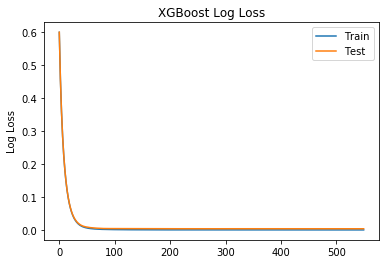

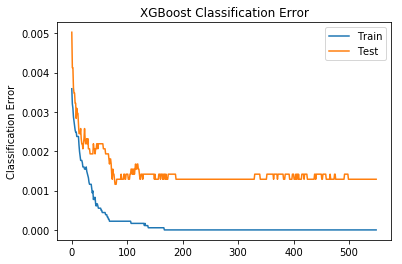

In [41]:
# make predictions for test data
y_pred = model3.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = specifity(predictions,y_test)
print("Accuracy: " +str(accuracy))
# retrieve performance metrics
results = model3.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)


# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()


# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

## GridSearch

## Plot

In [42]:
def model_specifity_ploter(df_specifity,score):
    """


    """

    #Gráficas
    specifity_test_plot = df_specifity.mean(axis=0).values
    df_specifity=df_specifity.T

    plt.subplots(figsize=(8, 3))
    plt.plot(values_search, specifity_test_plot,color="royalblue")
    plt.title(str(score))


  
    plt.tight_layout()
    plt.show() 

### Verification

In [43]:
def verification_model_score(
                            df,target,n_iteraciones,
                            iteraciones,n_iteracion):
    """
    
    
    """
    dataset = df.copy()
    #dataset.drop(["fecha"],axis=1,inplace=True)
    dataset.dropna(inplace=True)
    dataset.drop(lista[:],axis=1,inplace=True)

    X = dataset.loc[:, dataset.columns != target]
    y = dataset[target]

    #Definimos los conjuntos de prueba:

    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rd.randint(1,100))
    #Definimos los conjuntos de prueba:
    iteraciones = [entrada for entrada in range(n_iteraciones)] ##definimos el número de iteraciones
    
    df_confussion_test = pd.DataFrame(index=iteraciones, columns=["tn","fp","fn","tp"])
    df_confussion_mean_test = pd.DataFrame(index=[0,1], columns=[0,1])

    for iteracion in iteraciones:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rd.randint(1,100))
        model = XGBClassifier(params=parameters[n_iteracion])#definimos los parametros
        model_train = model.fit(X_train, y_train)#fit
        pred_test = model_train.predict(X_test)
        #confussion matrix
        df_confussion_test.iloc[iteracion,:] = confussion_matrix_function(y_test,pred_test).ravel()

    print(df_confussion_test)
    
    df_confussion_mean_test.iloc[0,:] = df_confussion_test.describe().iloc[1,0:2].values
    df_confussion_mean_test.iloc[1,:] = df_confussion_test.describe().iloc[1,2:4].values
    df_confussion_mean_test = df_confussion_mean_test.apply(pd.to_numeric, errors='ignore')

    sn.heatmap(df_confussion_mean_test, annot=True)

In [44]:
hora = 11

dataset = data_hour_merge_training.copy()
#dataset.drop(["fecha"],axis=1,inplace=True)
dataset.dropna(inplace=True)
dataset.drop(lista[:],axis=1,inplace=True)

X = dataset.loc[:, dataset.columns != "class"]
y = dataset["class"]

#Definimos los conjuntos de prueba:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rd.randint(1,100))

In [45]:
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█'):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print('\r%s |%s| %s%% %s' % (prefix, bar, percent, suffix), end = '\r')
    # Print New Line on Complete
    if iteration == total: 
        print()

In [46]:
def xgboost_autoparameter_tunning(
                                df,target,parameter_grid,resamples,
                                parameters_list,score=specifity): 
    
    intentos = [number for number in range(resamples)]
    parameters_numbers_position = [i for i in range(len(parameters))]
    df_specifity = pd.DataFrame(columns=parameters_numbers_position,index=intentos)
    toolbar_width = len(intentos)
    
    
    ## progress bar 
    l = len(intentos)
    # Initial call to print 0% progress
    printProgressBar(0, l, prefix = 'Intentos:', suffix = '', length = 50)

    for intento in range(len(intentos)):
        
        X_training, X_testing, y_training, y_testing = train_test_split(X, y, test_size=0.3,   
                                                                        random_state=rd.randint(100,200)) 
        specifity_test_list = []# para cada conjunto de parametr

        for parameter_value in range(len(parameters_numbers_position)): ## iteramos sobre el parámetro deseado 

            model = XGBClassifier(**parameters[parameter_value])
            train_model = model.fit(X_training, y_training) ##model fit

            pred_test = train_model.predict(X_testing)  # predict verification

            specifity_test = specifity(y_testing,pred_test)## specifity model
            specifity_test_list.append(specifity_test)# specifity of search values and numbers
            
            
        time.sleep(0.1)
            # Update Progress Bar
        printProgressBar(intento + 1, l, prefix = 'Intentos:', suffix = '', length = 50)

            #print(specifity_test)
        specifity_test_list
        #print(df_specifity)

        df_specifity.loc[intento,:] = specifity_test_list
        
        
        
    df_specifity = df_specifity.apply(pd.to_numeric, errors = 'coerce')
    time.sleep(0)
    maximo = max(df_specifity.mean(axis=0))

    pos_maximum = [i for i,j in enumerate(df_specifity.mean(axis=0)) if j == maximo][0]
    maximo = round(maximo,2)

    #print(round(df_specifity.mean(axis=0),2))

    #print(df_confussion_mean)
    model_specifity_ploter(df_specifity,specifity)
    print()
    print("El máximo es para n="+ str(pos_maximum) + "  k=" + str(parameters[pos_maximum]) + 
          " con un " +"score"+"=  " +  str(maximo))

# booster

Intentos: |██████████████████████████████████████████████████| 100.0% 


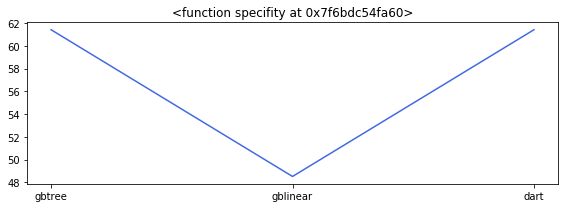


El máximo es para n=0  k={'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.01, 'max_delta_step': 0, 'max_depth': 10, 'n_estimators': 100, 'n_jobs': 100, 'nthread': None, 'objective': 'binary:logistic', 'verbosity': 1} con un score=  61.41


In [49]:
values_search=["gbtree","gblinear","dart"]
parameter_grid=values_search
parameters = [{ "booster":Serch_parameter, "colsample_bylevel":1,
 "colsample_bynode":1, "colsample_bytree":1, "gamma":0, "learning_rate":0.01,"max_delta_step":0, 
 "max_depth":10,"n_estimators":100, "n_jobs":100, "nthread":None,
 "objective":'binary:logistic', "verbosity":1} for Serch_parameter in parameter_grid]

xgboost_autoparameter_tunning(data_hour_merge_training,"class",parameter_grid,20,values_search)

## Verification

     tn  fp  fn  tp
0  7707   0  10  44
1  7704   4  20  33
2  7713   2  10  36
3  7706   3  18  34
4  7714   3  10  34


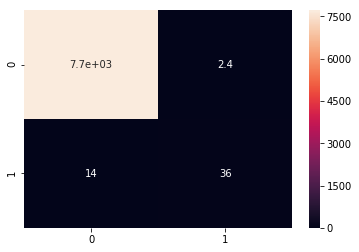

In [52]:
verification_model_score(data_hour_merge_training,"class",5,parameters,0)

### min_child_weight

Intentos: |██████████████████████████████████████████████████| 100.0% 


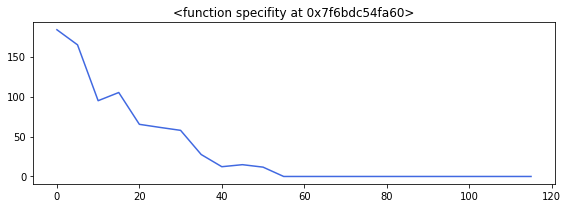


El máximo es para n=0  k={'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.9, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 0, 'missing': None, 'n_estimators': 65, 'n_jobs': 100, 'nthread': None, 'objective': 'binary:logitraw', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1} con un score=  183.71


In [53]:
parameter_grid=[i for i in range(0,120,5)]
values_search=parameter_grid
parameters = [{"base_score":0.5, "booster":'gbtree', "colsample_bylevel":1,
 "colsample_bynode":1, "colsample_bytree":1, "gamma":0, "learning_rate":0.9,"max_delta_step":0, 
 "max_depth":10, "min_child_weight":Serch_parameter, "missing":None,"n_estimators":65, "n_jobs":100, 
"nthread":None,"objective":'binary:logitraw', "random_state":0, "reg_alpha":0,
"reg_lambda":1, "scale_pos_weight":1, "seed":None, "silent":None,
"subsample":1, "verbosity":1} for Serch_parameter in parameter_grid]

xgboost_autoparameter_tunning(data_hour_merge_training,"class",parameter_grid,5,parameters)

     tn  fp  fn  tp
0  7697   0  17  47
1  7711   1  16  33
2  7706   1  11  43
3  7707   2  12  40
4  7716   1  15  29


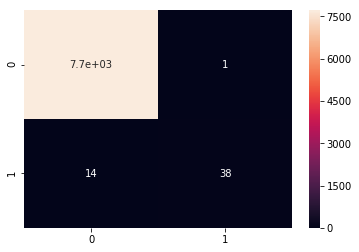

In [55]:
verification_model_score(data_hour_merge_training,"class",5,parameters,0)

### n_estimators

Intentos: |██████████████████████████████████████████████████| 100.0% 


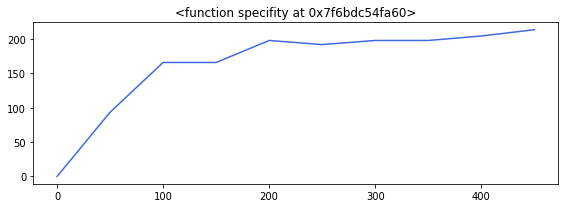


El máximo es para n=9  k={'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.03, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 0, 'missing': None, 'n_estimators': 450, 'n_jobs': 100, 'nthread': None, 'objective': 'binary:logitraw', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1} con un score=  213.73


In [57]:
parameter_grid=[i for i in range(0,500,50)]
values_search=parameter_grid
parameters = [{"base_score":0.5, "booster":'gbtree', "colsample_bylevel":1,
 "colsample_bynode":1, "colsample_bytree":1, "gamma":0, "learning_rate":0.03,"max_delta_step":0, 
 "max_depth":10, "min_child_weight":0, "missing":None,"n_estimators":Serch_parameter, "n_jobs":100, 
"nthread":None,"objective":'binary:logitraw', "random_state":0, "reg_alpha":0,
"reg_lambda":1, "scale_pos_weight":1, "seed":None, "silent":None,
"subsample":1, "verbosity":1} for Serch_parameter in parameter_grid]
xgboost_autoparameter_tunning(data_hour_merge_training,"class",parameter_grid,2,parameters)

     tn  fp  fn  tp
0  7702   2  20  37
1  7708   2  13  38
2  7712   0  13  36


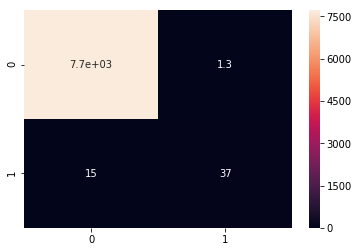

In [60]:
verification_model_score(data_hour_merge_training,"class",3,parameters,9)

#### Gamma

Intentos: |██████████████████████████████████████████████████| 100.0% 


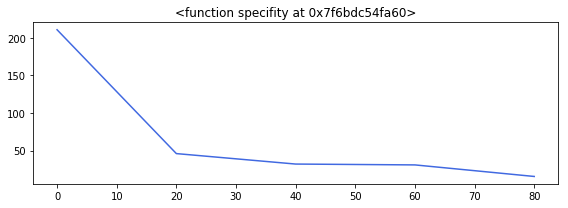


El máximo es para n=0  k={'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.03, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 0, 'missing': None, 'n_estimators': 100, 'n_jobs': 100, 'nthread': None, 'objective': 'binary:logitraw', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1} con un score=  210.66


In [62]:
parameter_grid=[i for i in range(0,100,20)]
values_search=parameter_grid
parameters = [{"base_score":0.5, "booster":'gbtree', "colsample_bylevel":1,
 "colsample_bynode":1, "colsample_bytree":1, "gamma":Serch_parameter, "learning_rate":0.03,"max_delta_step":0, 
 "max_depth":10, "min_child_weight":0, "missing":None,"n_estimators":100, "n_jobs":100, 
"nthread":None,"objective":'binary:logitraw', "random_state":0, "reg_alpha":0,
"reg_lambda":1, "scale_pos_weight":1, "seed":None, "silent":None,
"subsample":1, "verbosity":1} for Serch_parameter in parameter_grid]
xgboost_autoparameter_tunning(data_hour_merge_training,"class",parameter_grid,2,parameters)

      tn  fp  fn  tp
0   7714   1  11  35
1   7702   5  15  39
2   7710   2  13  36
3   7710   1  12  38
4   7707   2  12  40
5   7708   3  12  38
6   7714   0  11  36
7   7706   4  15  36
8   7708   3  12  38
9   7702   2  18  39
10  7708   1  10  42
11  7706   3  16  36
12  7708   3  12  38
13  7717   1  12  31


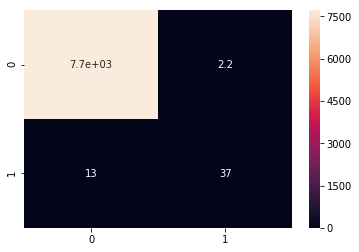

In [63]:
verification_model_score(data_hour_merge_training,"class",14,parameters,0)

## max_depth

Intentos: |██████████████████████████████████████████████████| 100.0% 


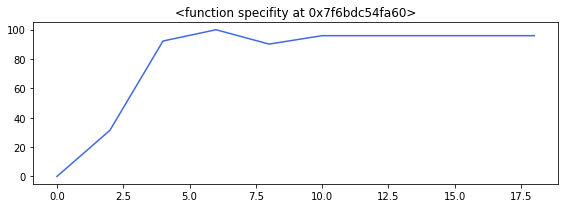


El máximo es para n=3  k={'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.03, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 0, 'missing': None, 'n_estimators': 100, 'n_jobs': 100, 'nthread': None, 'objective': 'binary:logitraw', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1} con un score=  99.93


In [70]:
parameter_grid=[i for i in range(0,20,2)]
values_search=parameter_grid
parameters = [{"base_score":0.5, "booster":'gbtree', "colsample_bylevel":1,
 "colsample_bynode":1, "colsample_bytree":1, "gamma":0, "learning_rate":0.03,"max_delta_step":0, 
 "max_depth":Serch_parameter, "min_child_weight":0, "missing":None,"n_estimators":100, "n_jobs":100, 
"nthread":None,"objective":'binary:logitraw', "random_state":0, "reg_alpha":0,
"reg_lambda":1, "scale_pos_weight":1, "seed":None, "silent":None,
"subsample":1, "verbosity":1} for Serch_parameter in parameter_grid]
xgboost_autoparameter_tunning(data_hour_merge_training,"class",parameter_grid,2,parameters)

     tn  fp  fn  tp
0  7722   1  12  26
1  7707   3  18  33
2  7706   1  11  43
3  7715   2   8  36
4  7708   1  10  42


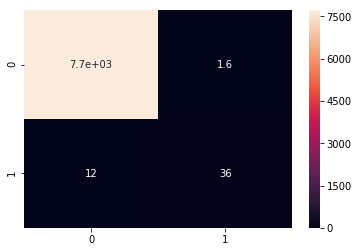

In [71]:
verification_model_score(data_hour_merge_training,"class",5,parameters,3)

## reg_alpha

Intentos: |██████████████████████████████████████████████████| 100.0% 


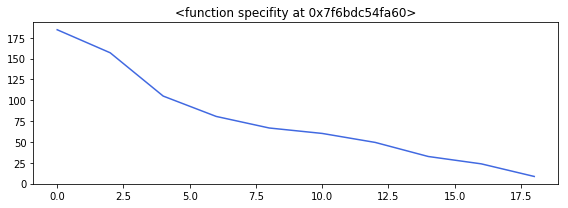


El máximo es para n=0  k={'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.03, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 0, 'missing': None, 'n_estimators': 100, 'n_jobs': 100, 'nthread': None, 'objective': 'binary:logitraw', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1} con un score=  184.66


In [72]:
parameter_grid=[i for i in range(0,20,2)]
values_search=parameter_grid
parameters = [{"base_score":0.5, "booster":'gbtree', "colsample_bylevel":1,
 "colsample_bynode":1, "colsample_bytree":1, "gamma":0, "learning_rate":0.03,"max_delta_step":0, 
 "max_depth":6, "min_child_weight":0, "missing":None,"n_estimators":100, "n_jobs":100, 
"nthread":None,"objective":'binary:logitraw', "random_state":0, "reg_alpha":Serch_parameter,
"reg_lambda":1, "scale_pos_weight":1, "seed":None, "silent":None,
"subsample":1, "verbosity":1} for Serch_parameter in parameter_grid]
xgboost_autoparameter_tunning(data_hour_merge_training,"class",parameter_grid,2,parameters)

     tn  fp  fn  tp
0  7697   3  16  45
1  7717   1  12  31


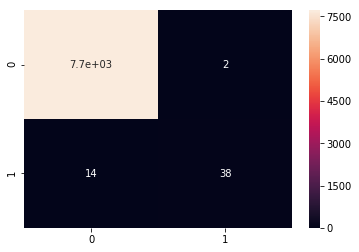

In [73]:
verification_model_score(data_hour_merge_training,"class",2,parameters,0)

### scale_pos_weight

Intentos: |██████████████████████████████████████████████████| 100.0% 


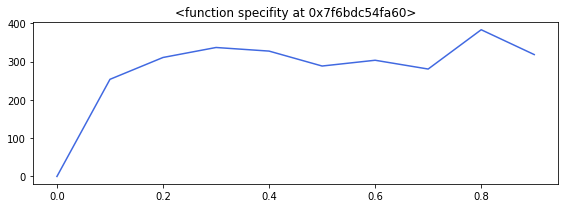


El máximo es para n=8  k={'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.8, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 0, 'missing': None, 'n_estimators': 100, 'n_jobs': 100, 'nthread': None, 'objective': 'binary:logitraw', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1} con un score=  383.03


In [79]:
parameter_grid=[i/100 for i in range(0,100,10)]
values_search=parameter_grid
parameters = [{"base_score":0.5, "booster":'gbtree', "colsample_bylevel":1,
 "colsample_bynode":1, "colsample_bytree":1, "gamma":0, "learning_rate":Serch_parameter,"max_delta_step":0, 
 "max_depth":6, "min_child_weight":0, "missing":None,"n_estimators":100, "n_jobs":100, 
"nthread":None,"objective":'binary:logitraw', "random_state":0, "reg_alpha":0,
"reg_lambda":1, "scale_pos_weight":1, "seed":None, "silent":None,
"subsample":1, "verbosity":1} for Serch_parameter in parameter_grid]
xgboost_autoparameter_tunning(data_hour_merge_training,"class",parameter_grid,3,parameters)

     tn  fp  fn  tp
0  7717   3  13  28
1  7713   2  10  36
2  7710   0  11  40
3  7713   3  11  34
4  7700   1  17  43


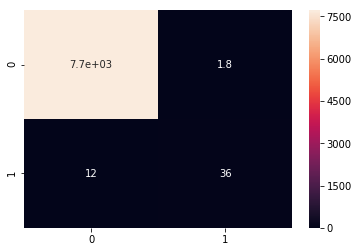

In [80]:
verification_model_score(data_hour_merge_training,"class",5,parameters,8)